In [1]:
import os
import numpy as np
import mne
import osl
import yaml
import pickle
from scipy.io import savemat
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from scipy.sparse import csr_matrix, vstack, coo_matrix, lil_matrix

# import loadmat
from scipy.io import loadmat

# import classifiers_linear from parent dir
import sys
sys.path.append('../')
import classifiers_linear

# import distance_riemann
from pyriemann.utils.distance import distance_riemann

In [101]:
# load data
chn = list(range(54))
x_train_ts = []
x_val_ts = []
x_test_ts = []

path = os.path.join('/', 'well', 'woolrich', 'projects',
                                 'disp_csaky', 'eeg',
                                 'preproc1_40hz_noica', 'inner_speech_long',
                                 'standard_scaler_norandom100sr0', 'c')

# load data for each channel
for index, i in enumerate(chn):
    data = loadmat(path + 'ch' + str(i) + '.mat')
    x_train_ts.append(np.array(data['x_train_t']))
    x_val_ts.append(np.array(data['x_val_t']))

    if index == 0:
        sub_id = np.array(data['sub_id_train'])

x_train = np.concatenate(tuple(x_train_ts), axis=1)
x_val = np.concatenate(tuple(x_val_ts), axis=1)

In [3]:
# load model
path = os.path.join('..',
            'results',
            'disp_epoched',
            'eeg',
            '9sessions_noica',
            'standard_cov_longepochs',
            'model.pt100')
model = pickle.load(open(path, 'rb'))

weights = model.model.coef_

In [102]:
y_train = x_train[:, -1, 0]
x_train = x_train[:, :-1, :]
x_val = x_val[:, :-1, :]

In [84]:
# remove mean over 3rd dimension in x_train
x_train = x_train - np.mean(x_train, axis=2, keepdims=True)
x_val = x_val - np.mean(x_val, axis=2, keepdims=True)

In [58]:
C = x_train.shape[1]
T = x_train.shape[2]
num_trials = x_train.shape[0]

# compute covariance
x = []
for t in range(x_train.shape[0]):
    mat = np.triu(np.cov(x_train[t])).reshape(-1)
    mat = mat[mat != 0]
    x.append(mat)

x = np.array(x)

y = np.dot(x, weights.T)

x_cov = np.cov(x.T)
y_cov = np.cov(y.T)

patterns = x_cov @ weights.T @ np.linalg.inv(y_cov)

In [59]:
# construct square covariance from upper triangular (patterns)
patterns_sq = []
for c in range(5):
    p = np.zeros((C, C))
    p[np.triu_indices(C)] = patterns[:, c]

    # fill lower triangular by mirroring upper triangular
    p[np.tril_indices(C)] = p.T[np.tril_indices(C)]

    patterns_sq.append(p)

In [60]:
ch_names = ['FPZ', 'F7', 'F5', 'F3', 'F1', 'F2', 'F4', 'F6', 'F8', 'FT9', 'FT7', 'FC5', 'FC1', 'FCZ', 'FC2', 'FC6', 'FT8', 'T9', 'T7', 'C5', 'C3', 'C1', 'C2', 'C4', 'C6', 'T8', 'T10', 'TP9', 'TP7', 'CP3', 'CP1', 'CPZ', 'CP2', 'CP4', 'TP8', 'TP10', 'P7', 'P5', 'P3', 'P1', 'PZ', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO3', 'PO4', 'PO8', 'O1', 'OZ', 'O2', 'IZ']

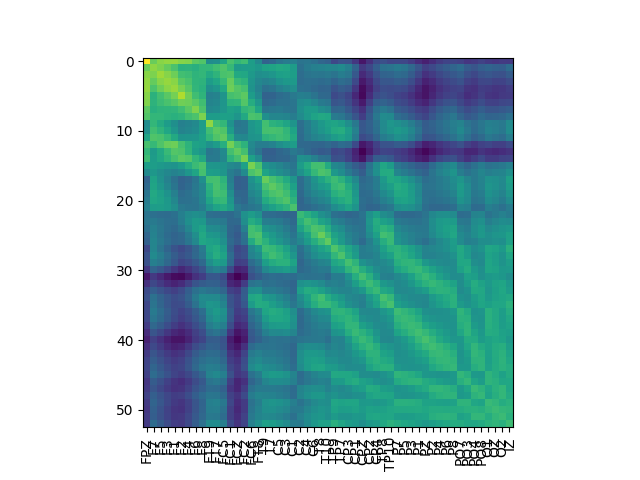

In [61]:
%matplotlib widget
plt.imshow(np.mean(patterns_sq, axis=0))
plt.xticks(range(0, 53), ch_names, rotation=90)
# add grid
#plt.grid()
e=0

In [31]:
C = x_train.shape[1]
T = x_train.shape[2]
num_trials = x_train.shape[0]

x_train_flat = x_train[:num_trials].reshape(num_trials, -1)
x_train_flat_div = x_train_flat / (T-1)

# Create the sparse matrix 'w' for all trials
w = lil_matrix((num_trials * C * T, C * (C // 2 + 1)), dtype=np.float64)

for t in range(num_trials):
    shift = t * C * T

    i = 0
    for c1 in range(C):
        ind0 = shift + c1 * T
        ind1 = shift + (c1 + 1) * T

        for c2 in range(c1, C):
            w[ind0:ind1, i] = x_train_flat_div[t, c2 * T:(c2 + 1) * T]

            i+=1

# convert to csr_matrix
w = w.tocsr()

# Compute 'combined_weight' for all trials
weights_csr = csr_matrix(weights.T, dtype=np.float64)
combined_weight = w @ weights_csr

# convert to dense matrix
combined_weight = combined_weight.toarray()

# reshape to 3D
combined_weight = combined_weight.reshape(num_trials, C*T, 5)

# Compute 'y' for all trials
y = np.einsum('ij,ijk->ik', x_train_flat, combined_weight)

# Compute 'x_cov' for all trials
x_cov = np.cov(x_train_flat.T)

# Compute 'y_cov' for all trials
y_cov = np.cov(y.T)

# Compute 'patterns' for all trials
patterns = np.dot(x_cov, combined_weight)
patterns = np.dot(patterns.transpose(1, 0, 2), np.linalg.inv(y_cov))

In [32]:
# save patterns
path = os.path.join('..',
            'results',
            'disp_epoched',
            'eeg',
            '9sessions_noica',
            'standard_cov_longepochs',
            'patterns_haufe.npy')

np.save(path, patterns)

In [70]:
path = os.path.join('..',
            'results',
            'disp_epoched',
            'eeg',
            '9sessions_noica',
            'standard_cov_longepochs',
            'ycov_haufe.npy')

np.save(path, y_cov)

In [28]:
x = np.arange(2*3).reshape(2, 3)
w = np.arange(2*3*4).reshape(2, 3, 4)

np.tensordot(x, w, axes=((1), (1)))

array([[[ 20,  23,  26,  29],
        [ 56,  59,  62,  65]],

       [[ 56,  68,  80,  92],
        [200, 212, 224, 236]]])

In [157]:
C = x_train.shape[1]
T = x_train.shape[2]
num_trials = 1

x_train_flat = x_train[:num_trials].reshape(num_trials, -1)

patterns_ = np.empty((num_trials, C * T, 5), dtype=np.float64)
for t in range(num_trials):
    x = x_train_flat[t]

    w = np.zeros((C * T, C * (C // 2 + 1)), dtype=np.float64)

    i = 0
    for c1 in range(C):
        for c2 in range(c1, C):
            vals = x[c2 * T:(c2 + 1) * T]
            w[c1 * T:(c1 + 1) * T, i] = vals/(T-1)

            i+=1

    combined_weight_ = np.dot(w, weights.T)
    y = np.dot(x, combined_weight_)

    x_cov_ = np.outer(x, x)
    y_cov_ = np.outer(y, y)

    patterns_[t, :, :] = np.dot(np.dot(x_cov_, combined_weight_), np.linalg.inv(y_cov_))

In [10]:
x_trans = x @ w
x_trans

array([0.59121374, 0.72985235, 0.68686234, ..., 2.5088939 , 2.0940346 ,
       2.07062691])

In [5]:
mat = np.triu(np.cov(x_train[0])).reshape(-1)
mat = mat[mat != 0]
mat

array([0.59121374, 0.72985235, 0.68686234, ..., 2.5088939 , 2.0940346 ,
       2.07062691])

In [33]:
# decompose weights into patterns according to Haufe transformation
# i can get a pattern matrix for each trial, but not for the whole dataset
# because the weight matrix is different for each trial

# look at the trial-wise patterns and at the average pattern over trials
patterns = patterns.reshape(num_trials, 53, 201, 5)

In [37]:
mean_patterns = np.mean(patterns, axis=0)

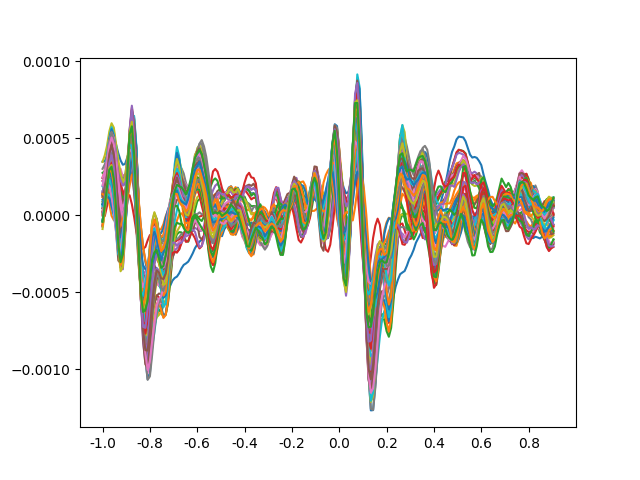

In [62]:
%matplotlib widget
plt.plot(np.mean(mean_patterns, axis=2).T)

# set x labels with decimal precision
plt.xticks(np.arange(0, 201, 21), np.arange(-10, 10, 2)/10)
e=0

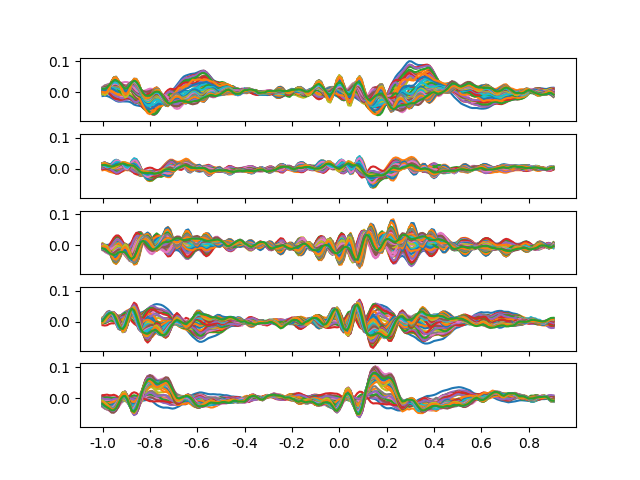

In [63]:
%matplotlib widget
# create 5 subplots
chn = 17
fig, axs = plt.subplots(5, 1, sharex=True, sharey=True)
for i in range(5):
    axs[i].plot(mean_patterns[:, :, i].T)

    # x labels should be -1 to 1
    axs[i].set_xticks(np.arange(0, 201, 21))

    # set x labels with decimal precision
    axs[i].set_xticklabels(np.arange(-10, 10, 2)/10)

In [65]:
updated_patterns = mean_patterns.reshape(-1, 5)

In [69]:
y = np.einsum('ij,ijk->ik', x_train_flat, combined_weight)

# Compute 'x_cov' for all trials
x_cov = np.cov(x_train_flat.T)

# Compute 'y_cov' for all trials
y_cov = np.cov(y.T)

In [86]:
# find least-squares mapping between the output of raw filter and y, through linear regression
filter = x_train_flat @ np.linalg.inv(x_cov) @ updated_patterns
y_cov_updated = np.linalg.inv(y.T @ y) @ y.T @ filter

In [115]:
# modify weights
updated_weights = np.linalg.inv(x_cov) @ updated_patterns @ y_cov_updated

In [78]:
model.model.intercept_

array([-22.20118715, -21.69031079, -22.57655166, -21.79681046,
       -21.78172404])

In [116]:
# compute accuracy
y_pred = x_train_flat @ updated_weights + model.model.intercept_

In [117]:
y_pred[0]

array([-1093.81768025,   494.37981144, -5594.2598532 , -2667.31008777,
        8210.40839179])

In [118]:
# compute accuracy
y_class = np.argmax(y_pred, axis=1)

np.equal(y_class, y_train).sum()/len(y_train)

0.2

In [111]:
# original model
x_t = []
for i in range(x_train.shape[0]):
    mat = np.triu(np.cov(x_train[i])).reshape(-1)
    mat = mat[mat != 0]
    x_t.append(mat)

x_t = np.array(x_t)

y_pred = x_t @ model.model.coef_.T + model.model.intercept_